In [ ]:
from session_7 import create_cifar10_dataloaders, AImageCompose, MetricsCallback, Model4
import matplotlib.pyplot as plt
from torchvision import transforms
from torchsummary import summary

import lightning as L
from lightning.pytorch.callbacks import TQDMProgressBar

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
L.seed_everything(0, workers=True)
model = Model4()
summary(model, input_size=(3, 32, 32))

Seed set to 0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           4,128
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]             320
           Conv2d-14           [-1, 32,

In [3]:
train_loader, test_loader = create_cifar10_dataloaders(
    batch_size=128,
    data_path="../data",
    train_transform=AImageCompose([ # type: ignore
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.CoarseDropout(
            num_holes_range=(1, 1),
            hole_height_range=(16, 16),
            hole_width_range=(16, 16),
            fill=tuple([x*255 for x in [0.4914, 0.4822, 0.4465]]),
            fill_mask=None,
            p=0.5
        ),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
        ToTensorV2(),
    ]),
    test_transform=AImageCompose(
        [
            A.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2470, 0.2435, 0.2616),
            ),
            ToTensorV2(),
        ]
    ),
)

/Users/firekind/Projects/personal/ERA4/session-7/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
metrics = MetricsCallback()
trainer = L.Trainer(
    max_epochs=50,
    logger=False,
    enable_checkpointing=False,
    callbacks=[TQDMProgressBar(leave=True), metrics],
)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | block1    | Sequential         | 9.4 K  | train
1 | block2    | Sequential         | 26.4 K | train
2 | block3    | Sequential         | 26.4 K | train
3 | block4    | Sequential         | 9.7 K  | train
4 | train_acc | MulticlassAccuracy | 0      | train
5 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
71.8 K    Trainable params
0         Non-trainable params
71.8 K    Total params
0.287     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 49: 100%|██████████| 391/391 [00:05<00:00, 77.53it/s, val_loss=0.437, val_acc=0.851, train_loss=0.559, train_acc=0.807]

`Trainer.fit` stopped: `max_epochs=50` reached.


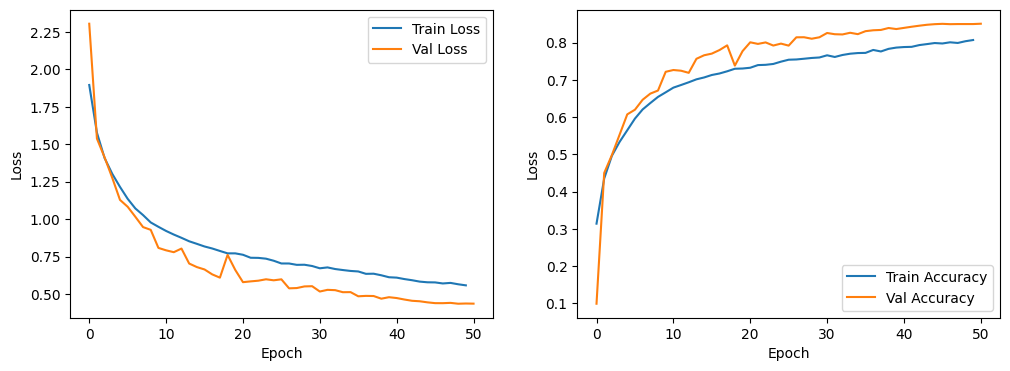

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
metrics.plot_loss(ax1)
metrics.plot_accuracy(ax2)
plt.show()

**Target**

Add depthwise separable convolutions, dilated convolutions to ([`Model3`](../src/session_7/model_3.py)), train with augmentations

**Result**

Block 2 and 3 now contain depthwise separable convolution, dialated convolution, strided convolution and 1x1 convolution. The channel transitions remain the same

Parameter Count: 71,838

Train Acc: 80.7%

Test Acc: 85.1%

**Analysis**

The target was achieved after 50 epochs of training, with a lesser parameter count.
